<center> <span style="color:red">

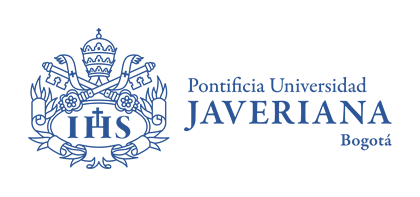
</center>

<font color='#3d67ff' size=30> <center>
**Procesamiento de Datos a Gran Escala**  
Parcial 
</center></font>

<font color='#00000' size=10> <center>
**La liga Inglesa**
</center></font>

# <font color='#3d67ff'> **Objetivo** </font>

#### **Identificar los mejores resultado para así lograr contratar el mejor equipo de la liga Inglesa.**

## Imports necesarios

In [0]:
import json
import numpy  as np
import pandas as pd
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from pandas import json_normalize
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from IPython.display import Image as PImage
from PIL import Image, ImageDraw, ImageFont
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

## Métodos Útiles

In [0]:
def read_json():
  with open(season_path, 'r') as f:
    d = json.load(f)
  return d

In [0]:
def read_through_original_data(d):
  team_table = {'match_id':[]}
  # read through original data
  for match_id,match_content in d.items():
    for match_stats in match_content.values():
        team_table['match_id'].append(match_id)
        
        for team_details_label,team_details in match_stats['team_details'].items():
            if team_details_label not in team_table.keys():
                team_table[team_details_label] = []
            team_table[team_details_label].append(team_details)
        
        for team_stats_label,team_stats in match_stats['aggregate_stats'].items():
            if team_stats_label not in team_table.keys():
                team_table[team_stats_label] = []
  for k,v in team_table.items():
    if len(v) == 0:
        team_table[k] = [np.nan] * len(team_table['match_id'])

  # indexing by match ID and team ID, if they both matches, fill in the real data
  for pos in range(len(team_table['match_id'])):
      for match_id,match_content in d.items():
          for team_id, match_stats in match_content.items():
              for team_stats_label,team_stats in match_stats['aggregate_stats'].items():
                  if (team_table['match_id'][pos] == match_id) & (team_table['team_id'][pos] == team_id):
                      team_table[team_stats_label][pos] = team_stats
  return team_table

In [0]:
# Encontrar cantidad datos atípicos para una columna de un dataframe:
def count_outliers(df, col):
  iqr_range = 2.5
  
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3 - q1
  low = q1 - iqr * iqr_range
  high = q3 + iqr * iqr_range

  return df.loc[((df[col] < low) | (df[col] > high))].shape[0]

In [0]:
#Función para encontrar el mejor resultado basado en los nodos de hoja
def get_mae_dtr(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)  

## Importación de los datos

In [0]:
players_path = 'https://drive.google.com/file/d/1d4ZarutP0MAuoaV5OlcL7iHVtJHU1cHD/view?usp=sharing'
results_path = 'https://drive.google.com/file/d/17-daS1fCmxZ1BFRUu_aE0QnVkwcn32BQ/view?usp=sharing'
season_path  = 'https://drive.google.com/file/d/128skbwEa6HfwHcWHLS4BnJth_Y9AQvKk/view?usp=sharing'

In [0]:
players = pd.read_csv(players_path)
results = (pd.read_json(results_path, orient='records')).transpose()
seasons = pd.DataFrame(read_through_original_data(read_json()))

## Exploración de los datos

### Players

In [0]:
players

,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3.0,Chile,0,4,1,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2.0,Germany,0,4,1,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2.0,Czech Republic,0,6,1,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1.0,England,0,4,1,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2.0,France,0,4,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,Edimilson Fernandes,West+Ham,21,CM,2,5.0,288,4.5,0.40%,38,2.0,Switzerland,0,1,20,0,1
457,Arthur Masuaku,West+Ham,23,LB,3,7.0,199,4.5,0.20%,34,4.0,Congo DR,0,2,20,0,1
458,Sam Byram,West+Ham,23,RB,3,4.5,198,4.5,0.30%,29,1.0,England,0,2,20,0,0
459,Ashley Fletcher,West+Ham,21,CF,1,1.0,412,4.5,5.90%,16,1.0,England,0,1,20,0,1


In [0]:
players = players[['name', 'age', 'position', 'market_value', 'nationality', 'club']]

Out[58]: <matplotlib.axes._subplots.AxesSubplot at 0x7f5d1af3d1d0>

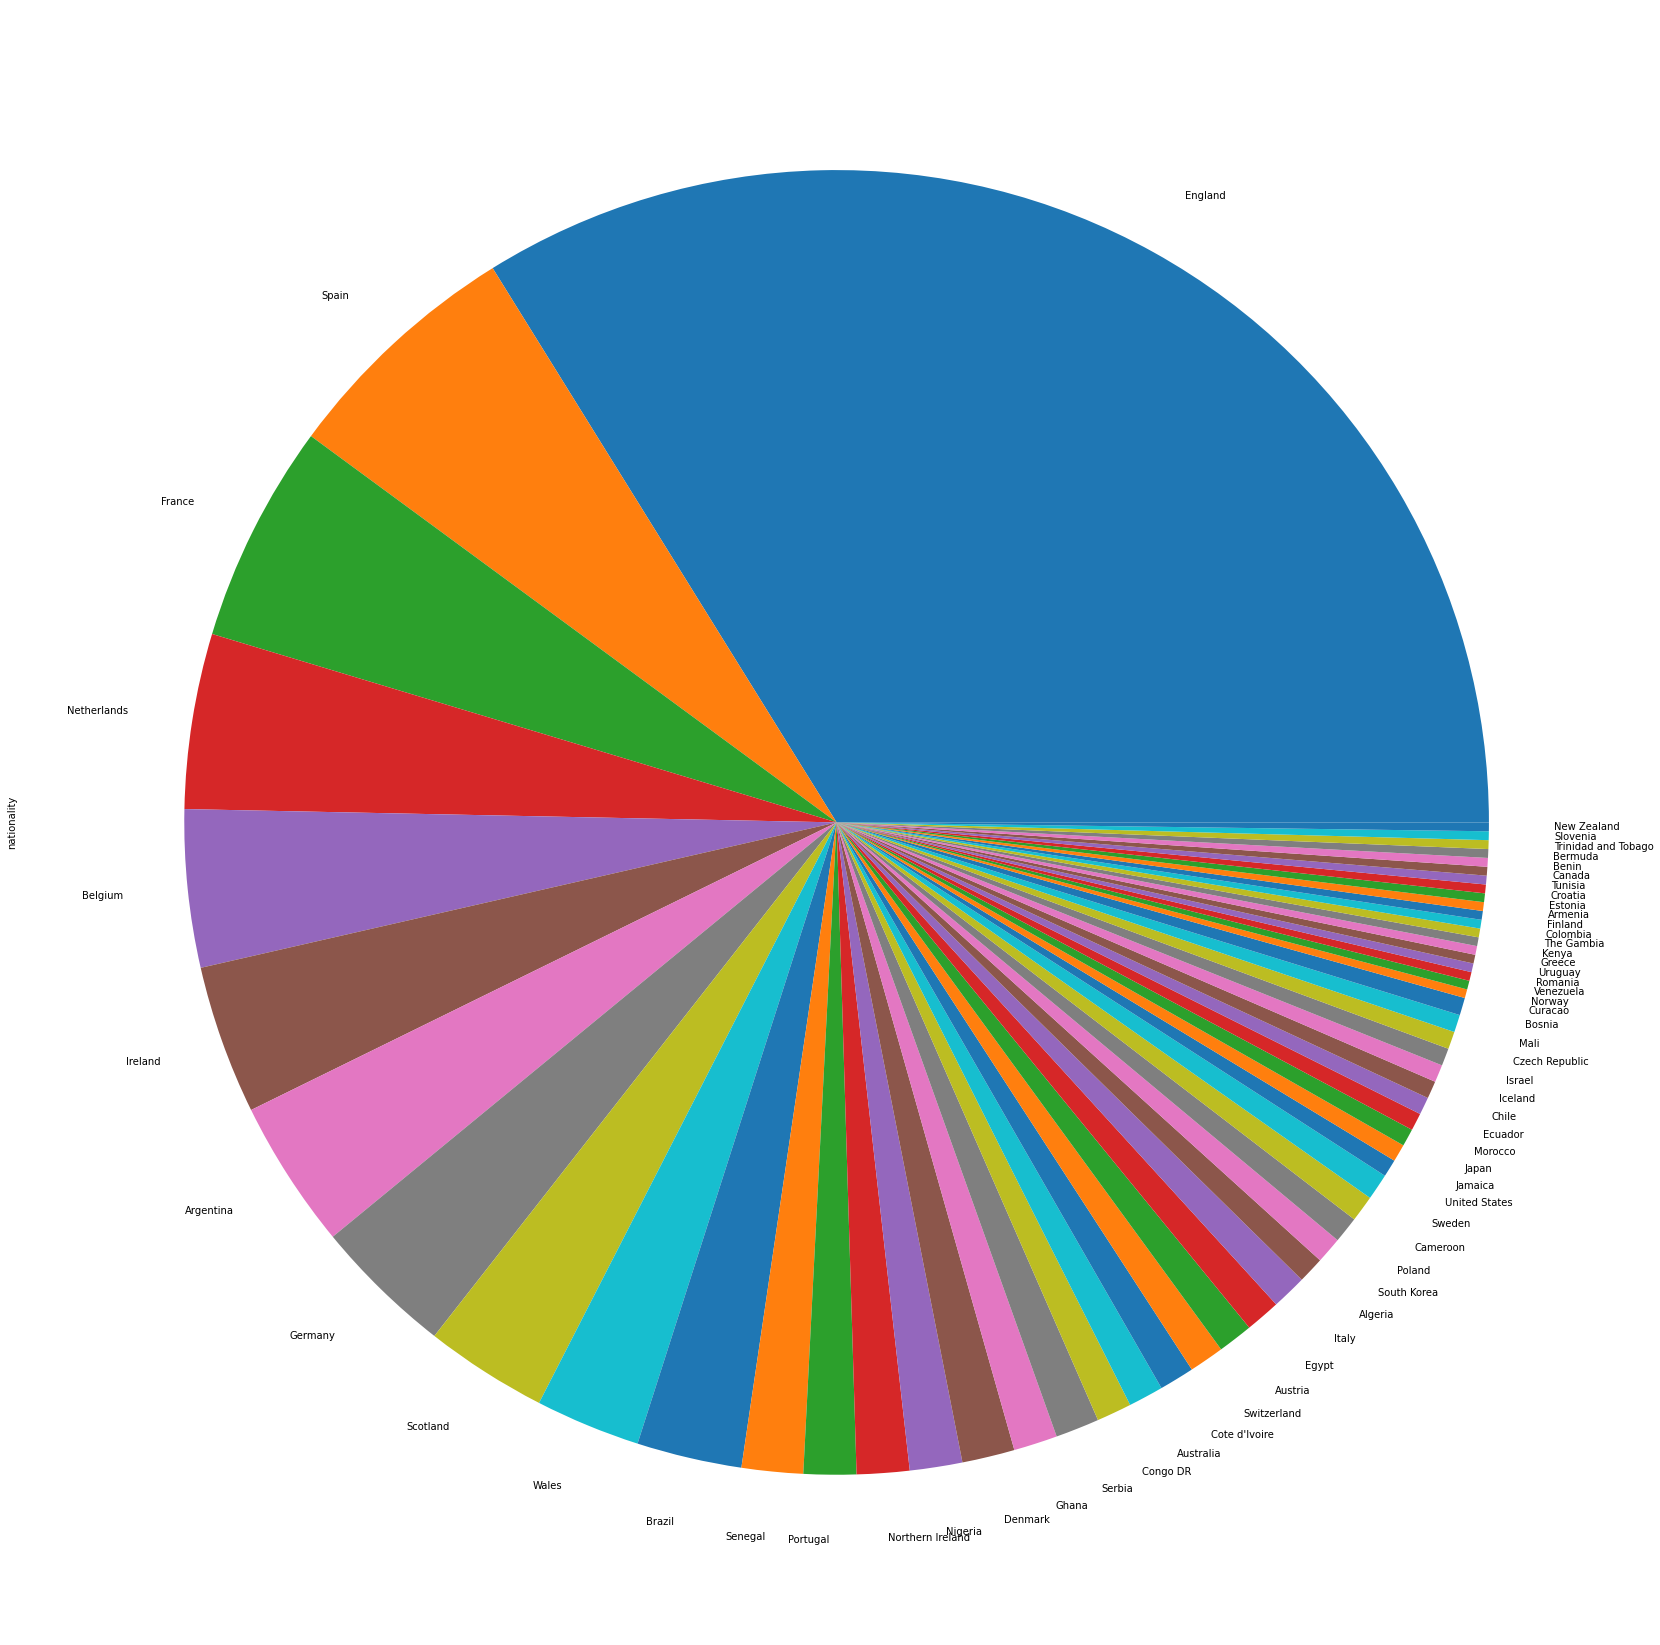

In [0]:
players['nationality'].value_counts().plot.pie(figsize=(30,30))

Out[59]: <matplotlib.axes._subplots.AxesSubplot at 0x7f5d1aff4e50>

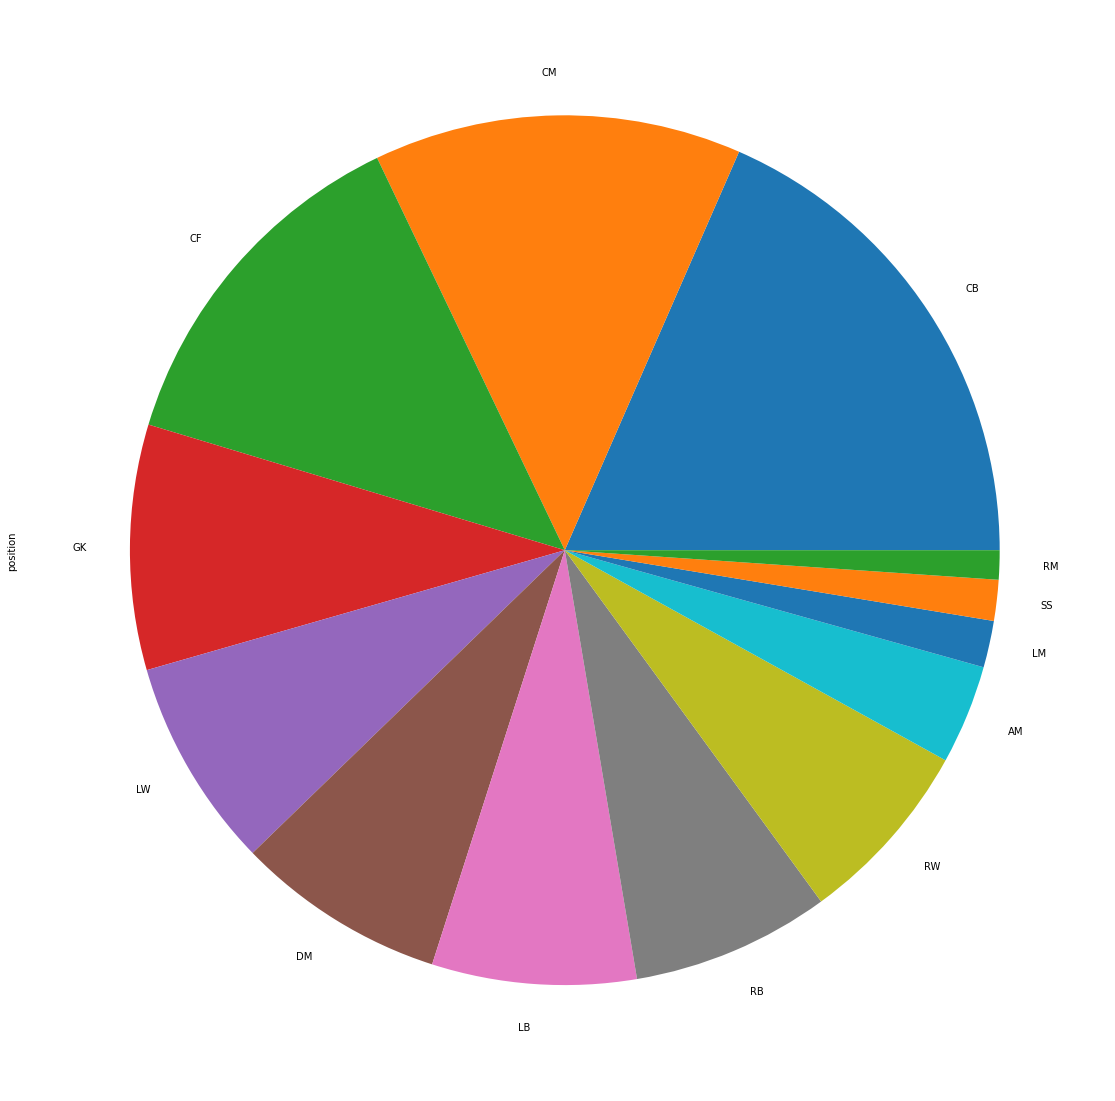

In [0]:
players['position'].value_counts().plot.pie(figsize=(20,20))

In [0]:
players.shape

Out[60]: (461, 6)

In [0]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461 entries, 0 to 460
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          461 non-null    object 
 1   age           461 non-null    int64  
 2   position      461 non-null    object 
 3   market_value  461 non-null    float64
 4   nationality   461 non-null    object 
 5   club          461 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 21.7+ KB


In [0]:
players.describe(include='object')

,name,position,nationality,club
count,461,461,461,461
unique,461,13,61,20
top,Alexis Sanchez,CB,England,Arsenal
freq,1,85,156,28


In [0]:
players.isnull().sum()

Out[63]: name            0
age             0
position        0
market_value    0
nationality     0
club            0
dtype: int64

In [0]:
# Mostrar por columna de tipo numérico la canntidad de datos atípicos
cols = players.select_dtypes(exclude=['object'])
print("Column => Count")
print("----------------------------------")
for col in cols:
  print(col, " => ", count_outliers(players, col))

Column => Count
----------------------------------
age  =>  0
market_value  =>  10


### Results

In [0]:
results

,home_team_id,away_team_id,home_team_name,away_team_name,date_string,half_time_score,full_time_score
1190418,166,26,Huddersfield,Liverpool,30/01/2018 20:00:00,0 : 2,0 : 3
1190424,211,183,Brighton,Bournemouth,01/01/2018 12:30:00,1 : 1,2 : 2
1190342,15,14,Chelsea,Leicester,13/01/2018 15:00:00,0 : 0,0 : 0
1190356,26,259,Liverpool,Swansea,26/12/2017 17:30:00,1 : 0,5 : 0
1190430,15,183,Chelsea,Bournemouth,31/01/2018 19:45:00,0 : 0,0 : 3
...,...,...,...,...,...,...,...
1190429,26,27,Liverpool,Watford,17/03/2018 17:30:00,2 : 0,5 : 0
1190415,29,27,West Ham,Watford,10/02/2018 15:00:00,1 : 0,2 : 0
1190373,13,27,Arsenal,Watford,11/03/2018 13:30:00,1 : 0,3 : 0
1190367,32,166,Manchester United,Huddersfield,03/02/2018 15:00:00,0 : 0,2 : 0


In [0]:
results.drop('half_time_score', axis=1, inplace=True)
results

,home_team_id,away_team_id,home_team_name,away_team_name,date_string,full_time_score
1190418,166,26,Huddersfield,Liverpool,30/01/2018 20:00:00,0 : 3
1190424,211,183,Brighton,Bournemouth,01/01/2018 12:30:00,2 : 2
1190342,15,14,Chelsea,Leicester,13/01/2018 15:00:00,0 : 0
1190356,26,259,Liverpool,Swansea,26/12/2017 17:30:00,5 : 0
1190430,15,183,Chelsea,Bournemouth,31/01/2018 19:45:00,0 : 3
...,...,...,...,...,...,...
1190429,26,27,Liverpool,Watford,17/03/2018 17:30:00,5 : 0
1190415,29,27,West Ham,Watford,10/02/2018 15:00:00,2 : 0
1190373,13,27,Arsenal,Watford,11/03/2018 13:30:00,3 : 0
1190367,32,166,Manchester United,Huddersfield,03/02/2018 15:00:00,2 : 0


In [0]:
results.shape

Out[67]: (380, 6)

In [0]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 1190418 to 1190401
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   home_team_id     380 non-null    object
 1   away_team_id     380 non-null    object
 2   home_team_name   380 non-null    object
 3   away_team_name   380 non-null    object
 4   date_string      380 non-null    object
 5   full_time_score  380 non-null    object
dtypes: object(6)
memory usage: 28.9+ KB


In [0]:
results.describe(include='object')

,home_team_id,away_team_id,home_team_name,away_team_name,date_string,full_time_score
count,380,380,380,380,380,380
unique,20,20,20,20,213,31
top,166,26,Huddersfield,Liverpool,13/05/2018 15:00:00,1 : 1
freq,19,19,19,19,10,45


In [0]:
scores = results['full_time_score'].str.split(':', expand=True)
scores.columns = ['score_home_team', 'score_away_team']

results = pd.concat([results,scores], axis=1)
results.drop('full_time_score', axis=1, inplace=True)
results

,home_team_id,away_team_id,home_team_name,away_team_name,date_string,score_home_team,score_away_team
1190418,166,26,Huddersfield,Liverpool,30/01/2018 20:00:00,0,3
1190424,211,183,Brighton,Bournemouth,01/01/2018 12:30:00,2,2
1190342,15,14,Chelsea,Leicester,13/01/2018 15:00:00,0,0
1190356,26,259,Liverpool,Swansea,26/12/2017 17:30:00,5,0
1190430,15,183,Chelsea,Bournemouth,31/01/2018 19:45:00,0,3
...,...,...,...,...,...,...,...
1190429,26,27,Liverpool,Watford,17/03/2018 17:30:00,5,0
1190415,29,27,West Ham,Watford,10/02/2018 15:00:00,2,0
1190373,13,27,Arsenal,Watford,11/03/2018 13:30:00,3,0
1190367,32,166,Manchester United,Huddersfield,03/02/2018 15:00:00,2,0


In [0]:
results = results.astype({'score_away_team':'int', 'score_home_team':'int', 'home_team_name':'string', 'away_team_name':'string'})
results.info()

conditions = [results['score_home_team'] > results['score_away_team'], results['score_home_team'] < results['score_away_team'] ]
options = ['Home_team', 'Away_team']

results['winner'] = np.select(conditions,options,default= 'Tie')
results

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 1190418 to 1190401
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   home_team_id     380 non-null    object
 1   away_team_id     380 non-null    object
 2   home_team_name   380 non-null    string
 3   away_team_name   380 non-null    string
 4   date_string      380 non-null    object
 5   score_home_team  380 non-null    int64 
 6   score_away_team  380 non-null    int64 
dtypes: int64(2), object(3), string(2)
memory usage: 31.9+ KB


,home_team_id,away_team_id,home_team_name,away_team_name,date_string,score_home_team,score_away_team,winner
1190418,166,26,Huddersfield,Liverpool,30/01/2018 20:00:00,0,3,Away_team
1190424,211,183,Brighton,Bournemouth,01/01/2018 12:30:00,2,2,Tie
1190342,15,14,Chelsea,Leicester,13/01/2018 15:00:00,0,0,Tie
1190356,26,259,Liverpool,Swansea,26/12/2017 17:30:00,5,0,Home_team
1190430,15,183,Chelsea,Bournemouth,31/01/2018 19:45:00,0,3,Away_team
...,...,...,...,...,...,...,...,...
1190429,26,27,Liverpool,Watford,17/03/2018 17:30:00,5,0,Home_team
1190415,29,27,West Ham,Watford,10/02/2018 15:00:00,2,0,Home_team
1190373,13,27,Arsenal,Watford,11/03/2018 13:30:00,3,0,Home_team
1190367,32,166,Manchester United,Huddersfield,03/02/2018 15:00:00,2,0,Home_team


In [0]:
for row in range(len(results)):
  if results.iloc[row]['winner'] == 'Home_team':
    results.iloc[row]['winner_name'] = results.iloc[row]['home_team_name']

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


In [0]:
results = results.astype({'winner':'string'})
filtro = results['winner'].apply(lambda row: row == ('Home_team'))
results.loc[filtro, 'winner_name'] = results.loc[filtro, 'home_team_name']

results = results.astype({'winner':'string'})
filtro = results['winner'].apply(lambda row: row == ('Away_team'))
results.loc[filtro, 'winner_name'] = results.loc[filtro, 'away_team_name']

results = results.astype({'winner':'string'})
filtro = results['winner'].apply(lambda row: row == ('Tie'))
results.loc[filtro, 'winner_name'] = 'Tie'

In [0]:
results

,home_team_id,away_team_id,home_team_name,away_team_name,date_string,score_home_team,score_away_team,winner,winner_name
1190418,166,26,Huddersfield,Liverpool,30/01/2018 20:00:00,0,3,Away_team,Liverpool
1190424,211,183,Brighton,Bournemouth,01/01/2018 12:30:00,2,2,Tie,Tie
1190342,15,14,Chelsea,Leicester,13/01/2018 15:00:00,0,0,Tie,Tie
1190356,26,259,Liverpool,Swansea,26/12/2017 17:30:00,5,0,Home_team,Liverpool
1190430,15,183,Chelsea,Bournemouth,31/01/2018 19:45:00,0,3,Away_team,Bournemouth
...,...,...,...,...,...,...,...,...,...
1190429,26,27,Liverpool,Watford,17/03/2018 17:30:00,5,0,Home_team,Liverpool
1190415,29,27,West Ham,Watford,10/02/2018 15:00:00,2,0,Home_team,West Ham
1190373,13,27,Arsenal,Watford,11/03/2018 13:30:00,3,0,Home_team,Arsenal
1190367,32,166,Manchester United,Huddersfield,03/02/2018 15:00:00,2,0,Home_team,Manchester United


Out[75]: <matplotlib.axes._subplots.AxesSubplot at 0x7f5d1b082650>

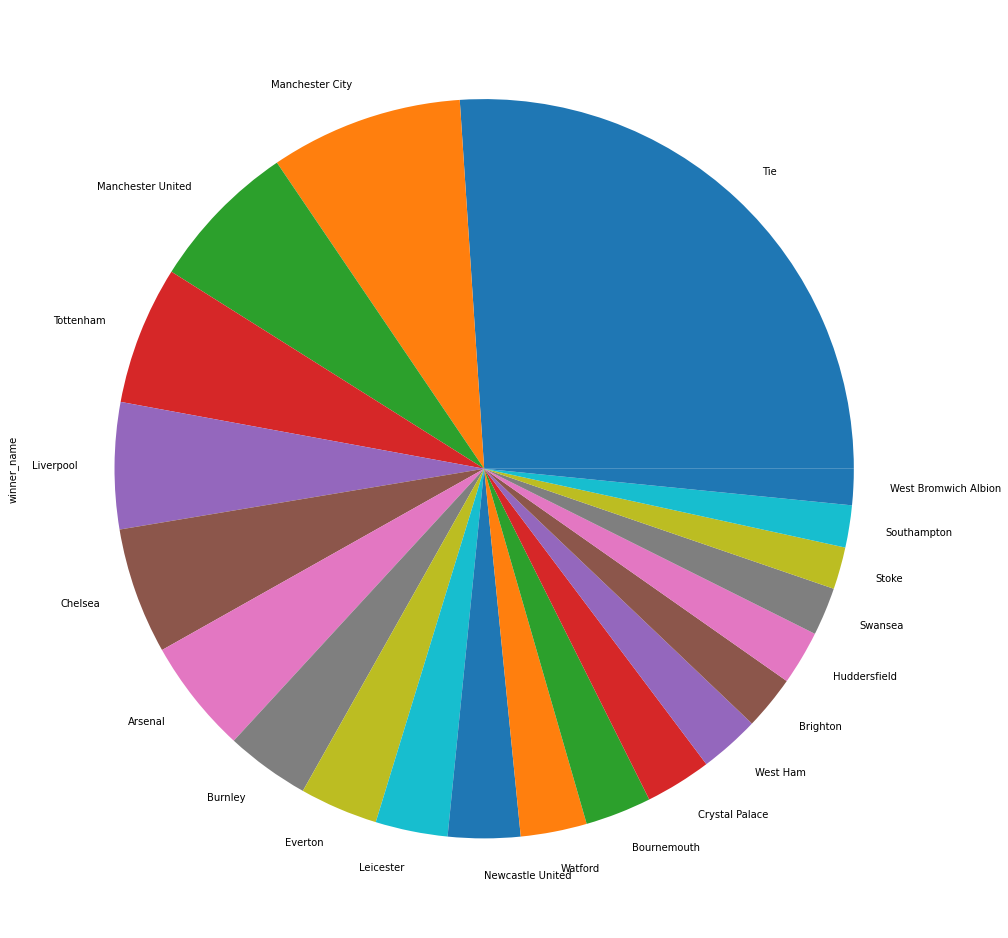

In [0]:
results['winner_name'].value_counts().plot.pie(figsize=(17,17))

In [0]:
results.isnull().sum()

Out[76]: home_team_id       0
away_team_id       0
home_team_name     0
away_team_name     0
date_string        0
score_home_team    0
score_away_team    0
winner             0
winner_name        0
dtype: int64

### Seasons

In [0]:
seasons

,match_id,team_id,team_name,team_rating,date,won_corners,att_sv_low_centre,won_contest,total_tackle,aerial_lost,...,att_sv_high_right,att_sv_low_right,att_sv_high_left,att_miss_high_left,att_goal_high_right,att_goal_high_left,att_post_right,att_goal_high_centre,penalty_save,att_post_high
0,1190418,166,Huddersfield,6.14,30/01/2018,1,1,5,11,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1190418,26,Liverpool,7.22285714285714,30/01/2018,4,2,6,13,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1190424,211,Brighton,7.15384615384615,01/01/2018,5,1,12,23,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1190424,183,Bournemouth,6.90285714285714,01/01/2018,12,3,17,6,25,...,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1190342,15,Chelsea,6.77142857142857,13/01/2018,6,1,15,13,18,...,NaN,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,1190373,27,Watford,6.17071428571429,11/03/2018,9,1,7,13,22,...,NaN,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
756,1190367,32,Manchester United,7.31928571428571,03/02/2018,5,3,27,15,18,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
757,1190367,166,Huddersfield,6.40857142857143,03/02/2018,2,NaN,4,22,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
758,1190401,96,Stoke,6.31076923076923,12/03/2018,3,NaN,9,19,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
seasons = seasons[['match_id', 'team_name', 'team_rating', 'possession_percentage', 'accurate_pass', 'total_pass']]
seasons

,match_id,team_name,team_rating,possession_percentage,accurate_pass,total_pass
0,1190418,Huddersfield,6.14,25.3,214,308
1,1190418,Liverpool,7.22285714285714,74.7,809,913
2,1190424,Brighton,7.15384615384615,49.1,300,394
3,1190424,Bournemouth,6.90285714285714,50.9,329,403
4,1190342,Chelsea,6.77142857142857,55.4,426,508
...,...,...,...,...,...,...
755,1190373,Watford,6.17071428571429,40.3,245,324
756,1190367,Manchester United,7.31928571428571,74.3,697,786
757,1190367,Huddersfield,6.40857142857143,25.7,190,265
758,1190401,Stoke,6.31076923076923,22.9,165,245


In [0]:
seasons.shape

Out[79]: (760, 6)

In [0]:
seasons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   match_id               760 non-null    object
 1   team_name              760 non-null    object
 2   team_rating            760 non-null    object
 3   possession_percentage  760 non-null    object
 4   accurate_pass          760 non-null    object
 5   total_pass             760 non-null    object
dtypes: object(6)
memory usage: 35.8+ KB


In [0]:
seasons.describe(include='object')

,match_id,team_name,team_rating,possession_percentage,accurate_pass,total_pass
count,760,760,760,760,760,760
unique,380,20,674,396,393,393
top,1190418,Huddersfield,6.43571428571429,59.6,288,415
freq,2,38,3,6,7,9


In [0]:
df = seasons[['team_name', 'team_rating']]
ratingMean = df.groupby('team_name', as_index=False).mean()
ratingMedian = df.groupby('team_name', as_index=False).median()

rating = pd.merge(ratingMean, ratingMedian, on='team_name')
rating.columns = ['team_name', 'median_team_rating']

rating

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


,team_name,median_team_rating
0,Arsenal,6.874615
1,Bournemouth,6.724368
2,Brighton,6.698929
3,Burnley,6.799615
4,Chelsea,6.990110
5,Crystal Palace,6.814231
6,Everton,6.700000
7,Huddersfield,6.652500
8,Leicester,6.675714
9,Liverpool,6.959643


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


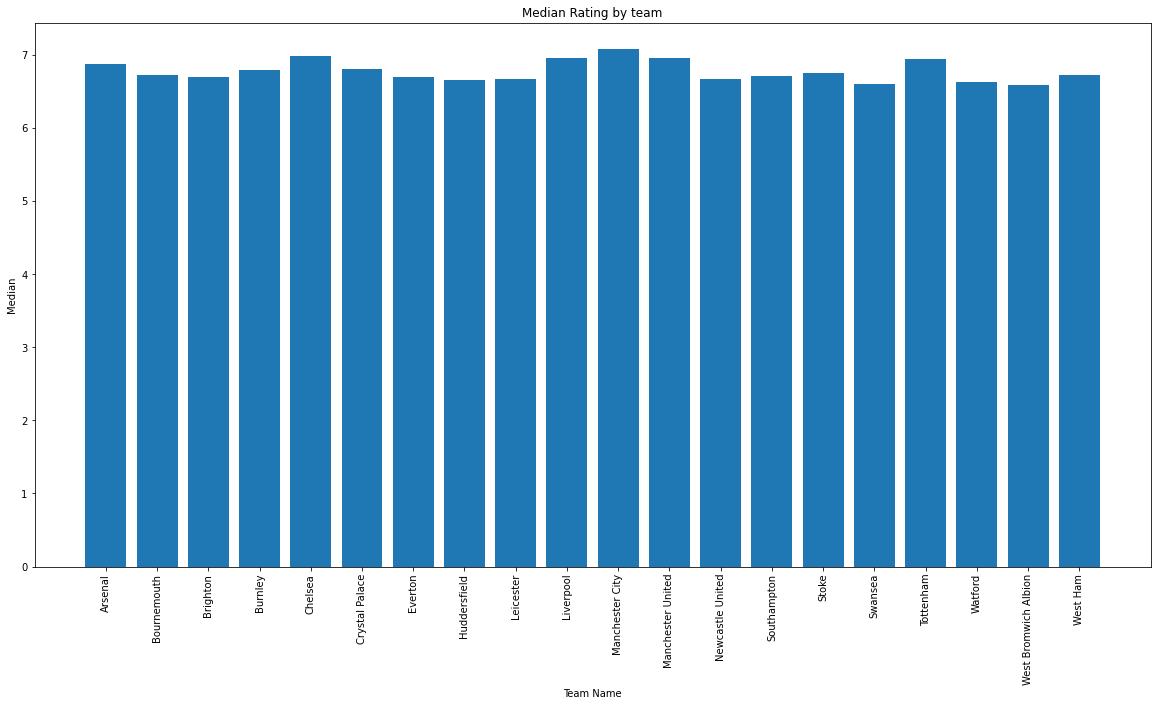

In [0]:
x_values = rating['team_name']
y_values = rating['median_team_rating']

plt.figure(figsize=(20,10))

plt.bar(x_values, y_values)
plt.title('Median Rating by team')
ax = plt.subplot()                   #Axis
ax.set_xticks(x_values)             #Eje x
ax.set_xticklabels(x_values, rotation=90)        #Etiquetas del eje x
ax.set_xlabel('Team Name')  #Nombre del eje x
ax.set_ylabel('Median')  #Nombre del eje y
plt.show()

In [0]:
df = seasons[['team_name', 'possession_percentage']]
possMean = df.groupby('team_name', as_index=False).mean()
possMedian = df.groupby('team_name', as_index=False).median()

possession = pd.merge(possMean, possMedian, on='team_name')
possession.columns = ['team_name', 'median_possesion']

possession

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


,team_name,median_possesion
0,Arsenal,64.15
1,Bournemouth,48.80
2,Brighton,43.40
3,Burnley,42.45
4,Chelsea,57.50
5,Crystal Palace,45.50
6,Everton,46.00
7,Huddersfield,48.30
8,Leicester,49.95
9,Liverpool,61.70


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


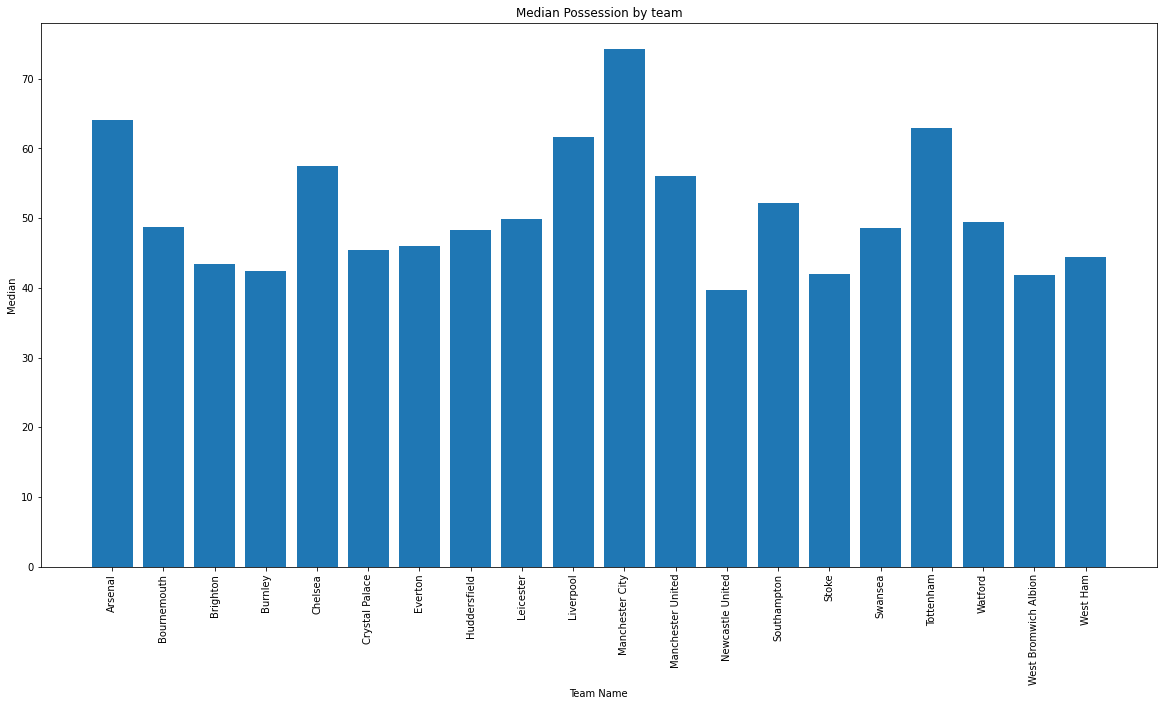

In [0]:
x_values = possession['team_name']
y_values = possession['median_possesion']

plt.figure(figsize=(20,10))

plt.bar(x_values, y_values)
plt.title('Median Possession by team')
ax = plt.subplot()                   #Axis
ax.set_xticks(x_values)             #Eje x
ax.set_xticklabels(x_values, rotation=90)        #Etiquetas del eje x
ax.set_xlabel('Team Name')  #Nombre del eje x
ax.set_ylabel('Median')  #Nombre del eje y
plt.show()

In [0]:
df = seasons[['team_name', 'accurate_pass']]
df2 = seasons[['team_name', 'total_pass']]
accurate = df.groupby('team_name', as_index=False).median()
total = df2.groupby('team_name', as_index=False).median()

passFrame = pd.merge(accurate, total, on='team_name')
passFrame.columns = ['team_name', 'median_accurate_pass', 'median_total_pass']

passFrame

,team_name,median_accurate_pass,median_total_pass
0,Arsenal,534.0,622.5
1,Bournemouth,329.5,420.0
2,Brighton,286.0,387.5
3,Burnley,249.0,361.0
4,Chelsea,471.0,555.5
5,Crystal Palace,285.0,378.5
6,Everton,302.0,400.0
7,Huddersfield,282.5,390.0
8,Leicester,314.0,415.0
9,Liverpool,509.5,594.5


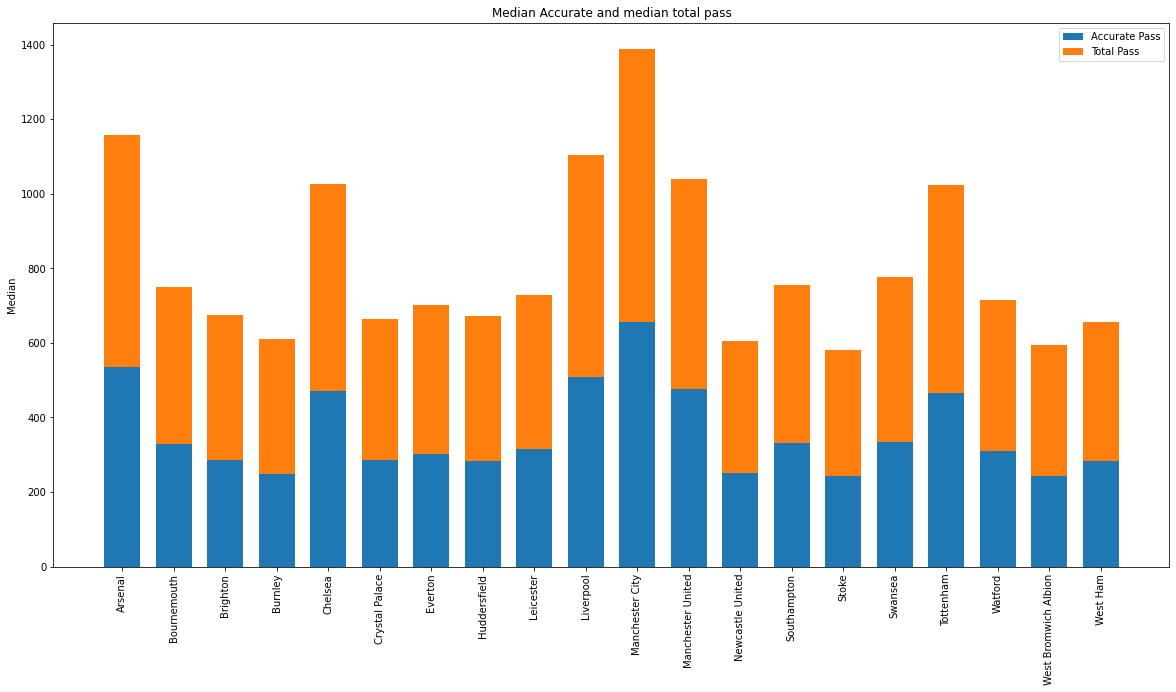

In [0]:
colors = ['#48a832','#a83240']          # Array de colores con los que se mostrará en el gráfico
x_values = passFrame['team_name']
y_values = passFrame['median_accurate_pass']
y2_values = passFrame['median_total_pass']

width = 0.7       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize = (20,10))

ax.bar(x_values, y_values, width,  label='Accurate Pass')
ax.bar(x_values, y2_values, width, bottom=y_values, label='Total Pass')

ax.set_ylabel('Median')
ax.set_xticklabels(x_values, rotation=90)        #Etiquetas del eje x
ax.set_title('Median Accurate and median total pass')
ax.legend()

plt.show()

In [0]:
seasons.isnull().sum()

Out[88]: match_id                 0
team_name                0
team_rating              0
possession_percentage    0
accurate_pass            0
total_pass               0
dtype: int64

### Hallazgos

In [0]:
team = ((results['winner_name'].value_counts().sort_values(ascending=False)).index[1])
name = team.split()
teamname= name[0]
teamname
players_team_winner = players.loc[players['club'].astype(str).str.contains(teamname)]
players_team_winner

,name,age,position,market_value,nationality,club
240,Kevin De Bruyne,26,AM,65.0,Belgium,Manchester+City
241,Sergio Aguero,29,CF,65.0,Argentina,Manchester+City
242,Raheem Sterling,22,LW,45.0,England,Manchester+City
243,Kyle Walker,27,RB,30.0,England,Manchester+City
244,David Silva,31,AM,30.0,Spain,Manchester+City
245,Leroy Sane,21,LW,35.0,Germany,Manchester+City
246,Nicolas Otamendi,29,CB,30.0,Argentina,Manchester+City
247,Aleksandar Kolarov,31,LB,10.0,Serbia,Manchester+City
248,Yaya Toure,34,CM,8.0,Cote d'Ivoire,Manchester+City
249,Fernandinho,32,DM,18.0,Brazil,Manchester+City


Out[90]: <matplotlib.axes._subplots.AxesSubplot at 0x7f5d1b1e09d0>

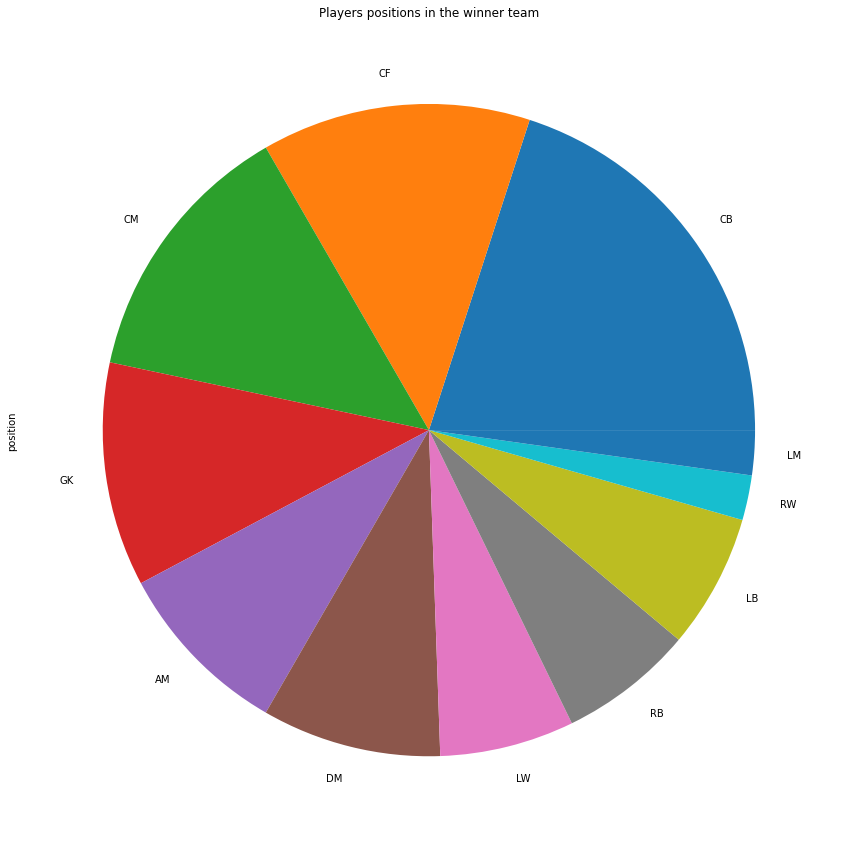

In [0]:
players_team_winner['position'].value_counts().plot.pie(figsize=(15,15), title = 'Players positions in the winner team')

In [0]:
urlWeb = "https://es.wikipedia.org/wiki/Premier_League"
datos = pd.read_html(urlWeb) # Leer todo el html
len(datos) # Imprimir en pantalla la cantidad de tablas leidas

Out[91]: 17

In [0]:
goleadores = datos[10]
goleadores.drop(4, axis=1, inplace=True)
goleadores.drop(6, axis=1, inplace=True)
goleadores.drop(0, axis=0, inplace=True)
goleadores.drop(1, axis=0, inplace=True)
goleadores.columns = ['Lugar','Jugador', 'Goles', 'Partidos', 'Disputa', 'Equipo']

In [0]:
goleadores

,Lugar,Jugador,Goles,Partidos,Disputa,Equipo
2,1,Alan Shearer,260,441,1992-93[72]​,Newcastle United (148)
3,2,Wayne Rooney,208,491,2002-03[73]​,Manchester United (183)
4,3,Harry Kane,195,296,2012-13[74]​,NaN
5,4,Andy Cole,187,414,1993-94[75]​,6 clubesManchester United (93)Blackburn Rovers...
6,5,Sergio Agüero,184,275,2011-12[76]​,NaN
7,6,Frank Lampard,177,609,1995-96[77]​,"Chelsea (147), Manchester City (6)"
8,7,Thierry Henry,175,258,1999-00[78]​,NaN
9,8,Robbie Fowler,163,379,1993-94[79]​,"Leeds United (14), Manchester City (21), Black..."
10,9,Jermain Defoe,162,496,2000-01[80]​,4 clubesTottenham Hotspur (91)Portsmouth (15)S...
11,10,Michael Owen,150,326,1996-97[81]​,"Newcastle United (26), Manchester United (5), ..."


In [0]:
players_gw = goleadores.loc[goleadores['Equipo'].astype('str').str.contains(teamname)]
array = players_gw['Jugador'].unique()
len(array)

Out[94]: 10

In [0]:
potenciales = players_team_winner.loc[(players_team_winner['name'] == array[0]) | (players_team_winner['name'] == array[1]) | (players_team_winner['name'] == array[2]) | (players_team_winner['name'] == array[3]) | (players_team_winner['name'] == array[4]) | (players_team_winner['name'] == array[5]) | (players_team_winner['name'] == array[6]) | (players_team_winner['name'] == array[7]) | (players_team_winner['name'] == array[8]) | (players_team_winner['name'] == array[9])]
potenciales

,name,age,position,market_value,nationality,club
260,Romelu Lukaku,24,CF,50.0,Belgium,Manchester+United


In [0]:
all_players = players[['name', 'market_value', 'position']]
all_g = goleadores[['Jugador', 'Lugar']]
all = pd.merge(all_players, all_g, how='outer', indicator='Result', sort=True, left_on='name', right_on='Jugador')

selected = all[all['Result']=='both']
selected.drop('Jugador', axis=1, inplace=True)
selected

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,name,market_value,position,Lugar,Result
160,Harry Kane,60.0,CF,3,both
189,Jamie Vardy,15.0,CF,14,both
200,Jermain Defoe,5.0,CF,9,both
321,Mohamed Salah,35.0,RW,16,both
380,Romelu Lukaku,50.0,CF,20,both
457,Wayne Rooney,15.0,SS,2,both


# Uso de Machine Learning

## Separación del dataset en train y test

In [0]:
trainresults, testresults = train_test_split(results, test_size = 0.30, shuffle = False)

In [0]:
trainseasons, testseasons = train_test_split(seasons, test_size = 0.30, shuffle = False)

## Tecnicas de Machine Learning

In [0]:
trainseasons

,match_id,team_name,team_rating,possession_percentage,accurate_pass,total_pass
0,1190418,Huddersfield,6.140000,25.3,214.0,308.0
1,1190418,Liverpool,7.222857,74.7,809.0,913.0
2,1190424,Brighton,7.153846,49.1,300.0,394.0
3,1190424,Bournemouth,6.902857,50.9,329.0,403.0
4,1190342,Chelsea,6.771429,55.4,426.0,508.0
...,...,...,...,...,...,...
527,1190312,Crystal Palace,6.548333,31.6,185.0,268.0
528,1190306,Huddersfield,6.358571,20.5,94.0,184.0
529,1190306,Manchester City,6.797143,79.5,642.0,733.0
530,1190460,West Ham,7.125714,56.6,396.0,479.0


In [0]:
trainseasons['team_rating'] = trainseasons['team_rating'].astype(float, errors = 'raise')
trainseasons['possession_percentage'] = trainseasons['possession_percentage'].astype(float, errors = 'raise')
trainseasons['accurate_pass'] = trainseasons['accurate_pass'].astype(float, errors = 'raise')
trainseasons['total_pass'] = trainseasons['total_pass'].astype(float, errors = 'raise')

In [0]:
trainseasons.dtypes

Out[123]: match_id                  object
team_name                 object
team_rating              float64
possession_percentage    float64
accurate_pass            float64
total_pass               float64
dtype: object

In [0]:
lr = trainseasons.select_dtypes(exclude='object').copy() # Excluir todas las columnas que no sean de tipo númerico
lr = lr.replace(0, np.nan).dropna(axis=1)         # Las columnas con valor cero se remplazan con NaN y todas estas se eliminan

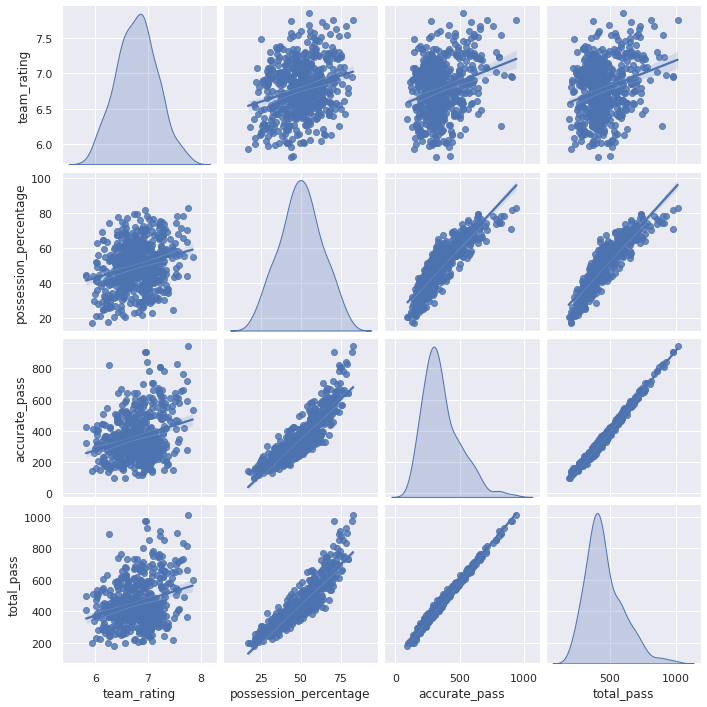

In [0]:
sns.set()                                     # Configurar el estilo de las gráficas
sns.pairplot(lr,diag_kind='kde',kind ='reg')  # Generar la matriz de gráficos
plt.show()                                    # Mostrar el gráfico

In [0]:
# Regresión Lineal
slr = lr[['team_rating']] 
sp = lr['total_pass']

train_x, valid_x, train_y, valid_y = train_test_split(slr, sp, train_size=0.8, random_state=0)

simple = LinearRegression()
simple.fit(train_x, train_y)

pred = simple.predict(valid_x)

result = mean_absolute_error(pred, valid_y)

print('Regresión Lineal Simple: ', result)

Regresión Lineal Simple:  107.91949778931826


In [0]:
# Regresión Lineal Míltiple
mlr = lr[['team_rating','possession_percentage','accurate_pass','total_pass']]

X_train, X_valid, y_train, y_valid = train_test_split(mlr, sp, train_size=0.8, test_size=0.2,random_state=0)

multiple_linear = LinearRegression()
multiple_linear.fit(X_train, y_train)
pred1 = multiple_linear.predict(X_valid)

result2 = mean_absolute_error(pred1, y_valid)
print('Regresión Lineal Múltiple: ',result2)

Regresión Lineal Múltiple:  2.86873328830246e-14


## Arboles

In [0]:
scores = {leaf_size: get_mae_dtr(leaf_size, X_train, X_valid, y_train, y_valid) for leaf_size in range(5,1000,50)}
best_tree_size = min(scores, key=scores.get) # Encontrar el tamaño de arbol ideal

mae_decision = scores[best_tree_size]
print('Tamaño ideal : ',best_tree_size)
print('MAE: ',mae_decision)

Tamaño ideal :  305
MAE:  1.794392523364486


## Segmentacion K-Means

In [0]:
# Agruparemos las casas según el área ocupada por varios pisos y sótano

feat = ['team_rating','possession_percentage','accurate_pass','total_pass']

def clusters(train):
    X = train.copy()
    X_scaled = (X - X.mean(axis=0))/X.std(axis=0)
    kmeans = KMeans(n_clusters=15, n_init=10, max_iter=400, random_state=0)
    kmeans = kmeans.fit_predict(X_scaled)
    X['clusters'] = np.array(kmeans)
    return X

clustering_df = clusters(trainseasons[feat])

clustering_df

,team_rating,possession_percentage,accurate_pass,total_pass,clusters
0,6.140000,25.3,214.0,308.0,13
1,7.222857,74.7,809.0,913.0,8
2,7.153846,49.1,300.0,394.0,0
3,6.902857,50.9,329.0,403.0,10
4,6.771429,55.4,426.0,508.0,14
...,...,...,...,...,...
527,6.548333,31.6,185.0,268.0,13
528,6.358571,20.5,94.0,184.0,13
529,6.797143,79.5,642.0,733.0,7
530,7.125714,56.6,396.0,479.0,12


<Figure size 432x432 with 0 Axes>

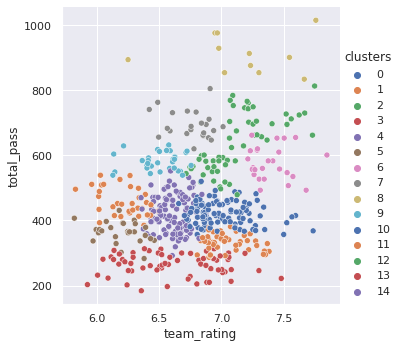

<Figure size 432x432 with 0 Axes>

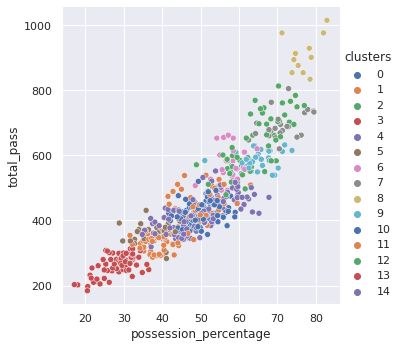

<Figure size 432x432 with 0 Axes>

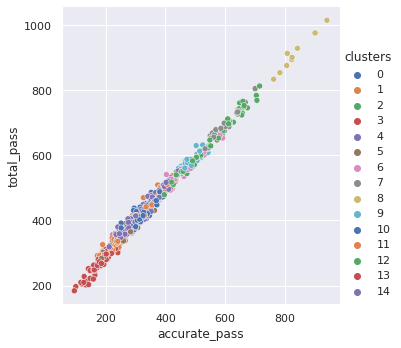

<Figure size 432x432 with 0 Axes>

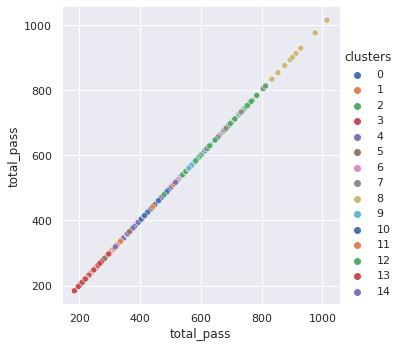

In [0]:
# Graficación de los puntos
y = trainseasons['total_pass']
feat = ['team_rating','possession_percentage','accurate_pass','total_pass']
for idx,col in enumerate(feat):
    plt.figure(idx, figsize=(6,6))
    sns.relplot(x=col,
            y=y, 
            hue='clusters',
            kind='scatter',
            palette='deep',
            data=clustering_df)
    plt.show()

Out[129]: <seaborn.axisgrid.FacetGrid at 0x7f5d096e3790>

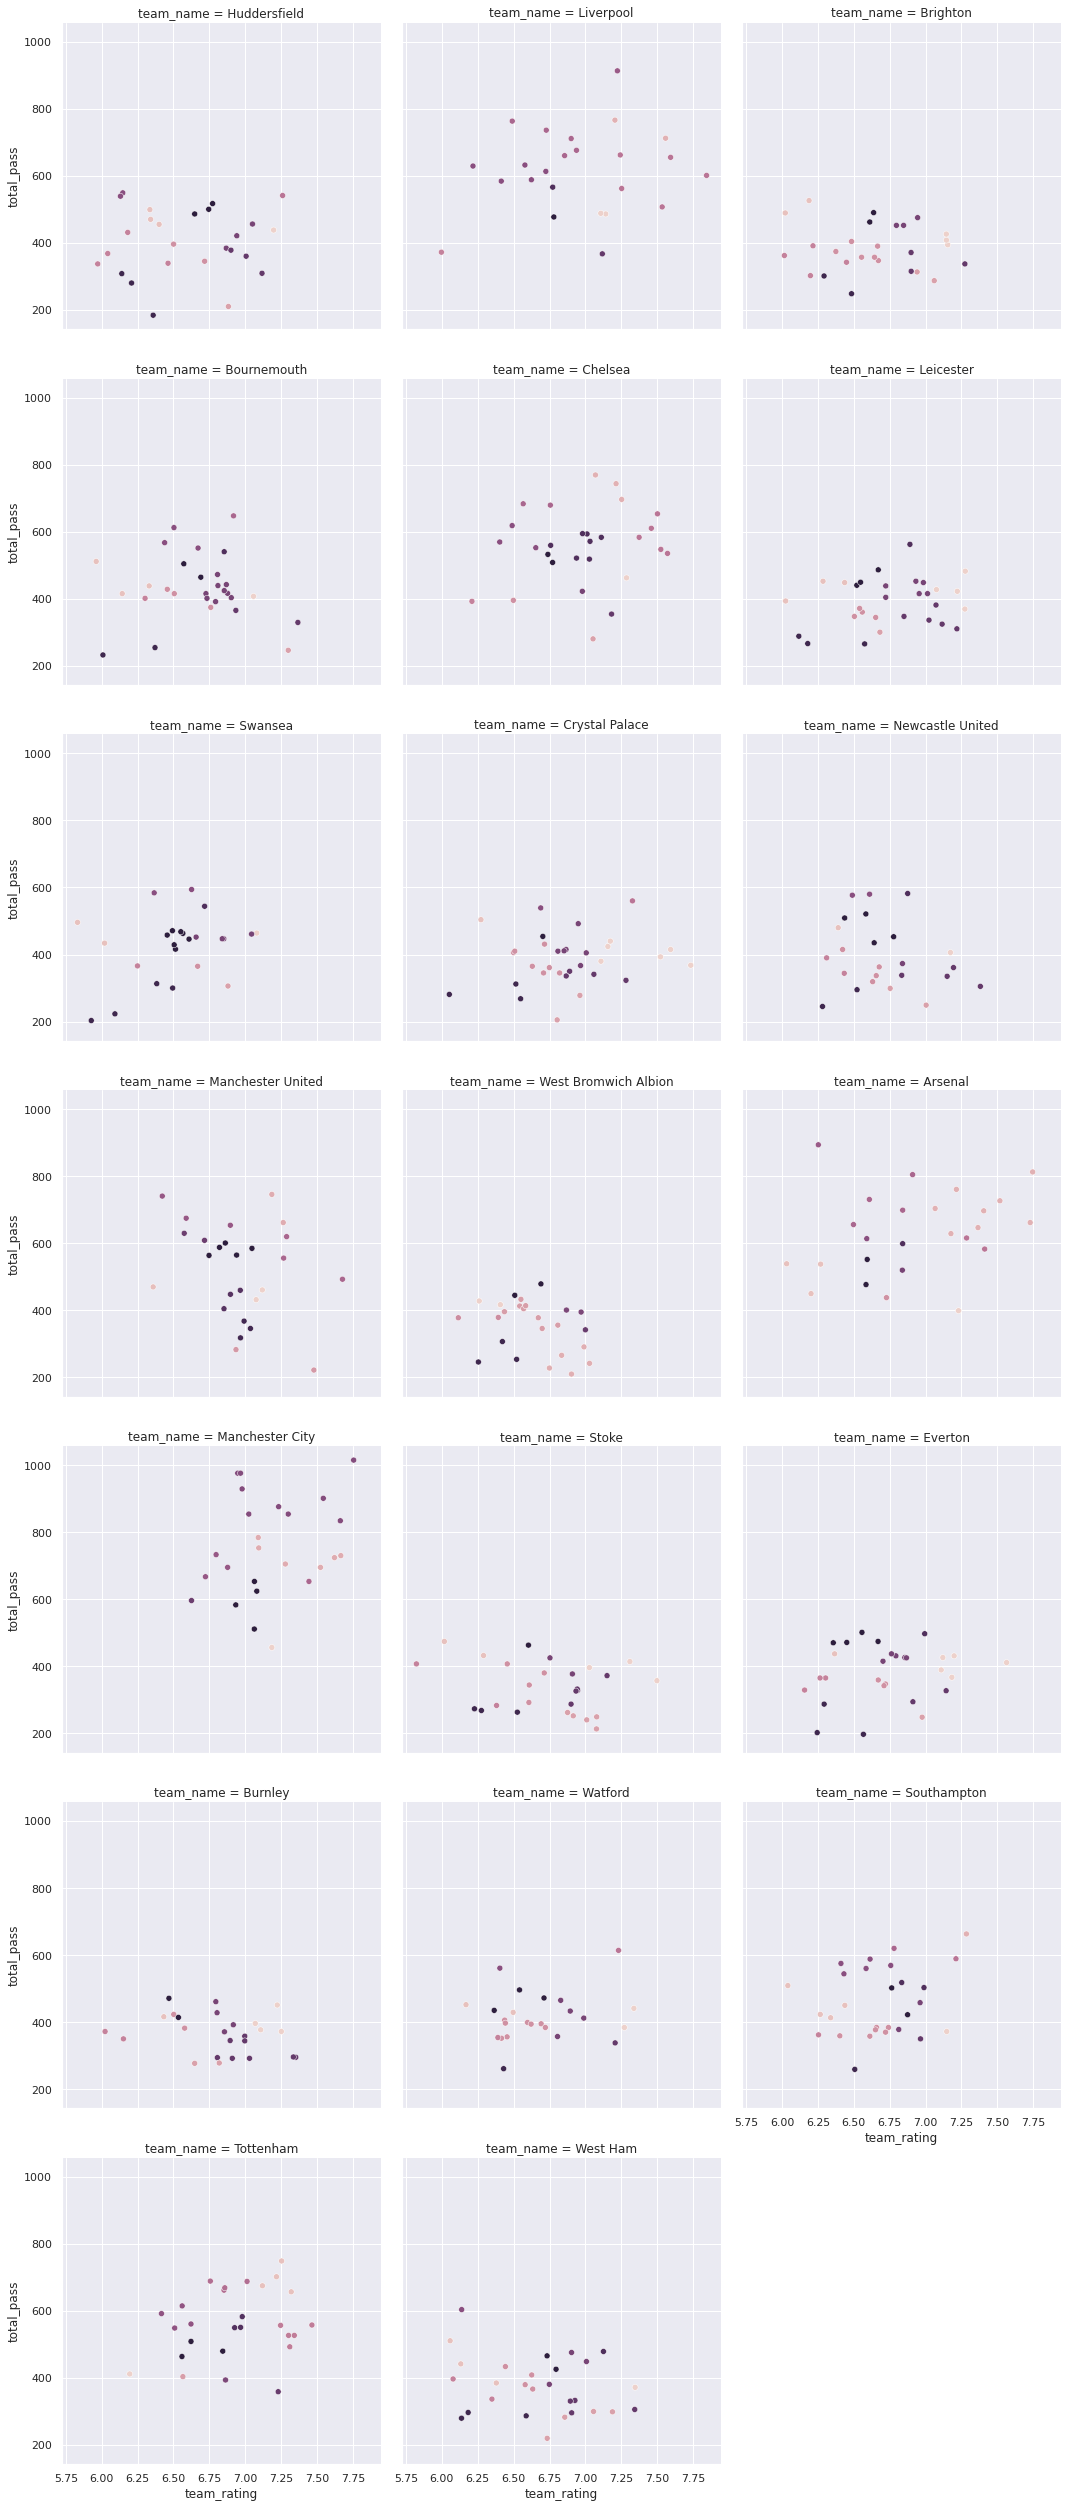

In [0]:
data2 = clustering_df.copy()
data2['team_name'] = trainseasons['team_name']
data2['total_pass'] = trainseasons['total_pass']

# Graficando la vecindad

g = sns.FacetGrid(data2, col='team_name',height= 5,
                aspect= 1,
                col_wrap=3,
                palette='deep')
g.map_dataframe(sns.scatterplot,
                x='team_rating', 
                y='total_pass', 
                hue='clusters')

## Optimizar el modelo

In [0]:
# Separar el conjunto de validación de los datos de entrenamiento
y = trainseasons.total_pass
trainseasons.drop(['total_pass'], axis=1, inplace=True)

X_train_full, X_valid_full, y_train, y_valid = train_test_split(trainseasons, y,train_size=0.8, test_size=0.2, random_state=0)
                                                                                                                  
# "Cardinalidad" significa el número de valores únicos en una columna
# Seleccionar columnas categóricas con cardinalidad relativamente baja (conveniente pero arbitraria)
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

# Seleccionar columnas númericad
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Conservar solo las columnas seleccionadas
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = testseasons[my_cols].copy()

In [0]:
# Preprocesamiento de datos numéricos
numerical_transformer = SimpleImputer(strategy='constant')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocesamiento de paquetes para datos numéricos y categóricos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model= XGBRegressor(n_estimators=350, learning_rate=0.05)

# Paquete de preprocesamiento y código de modelado en un pipeline
pipe_model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])
# Preprocesamiento de datos de entrenamiento, modelo de ajuste
pipe_model.fit(X_train, y_train)

# Preprocesamiento de datos de validación, obtener predicciones
preds = pipe_model.predict(X_valid)

mae_optimize = mean_absolute_error(y_valid, preds)
print('MAE after model opimization:', mae_optimize)

[17:00:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE after model opimization: 10.993330197913624


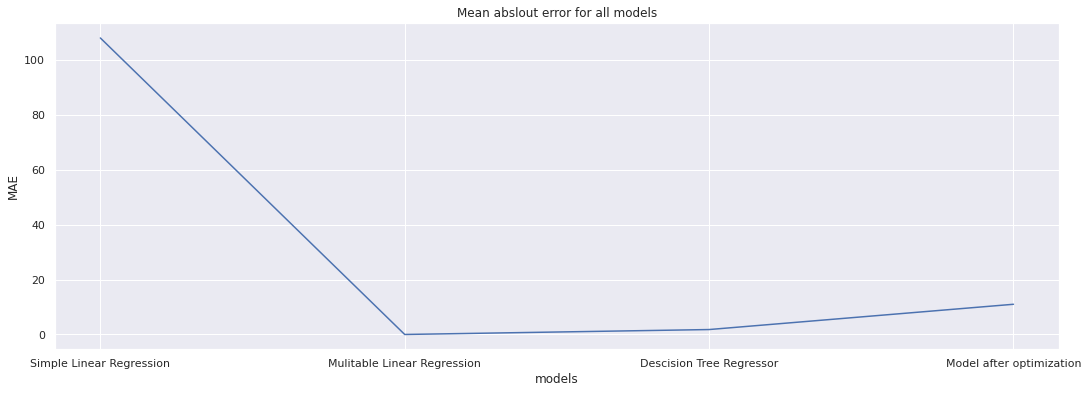

In [0]:
mae = {'Simple Linear Regression':result,
       'Mulitable Linear Regression':result2,
      'Descision Tree Regressor': mae_decision,
      'Model after optimization': mae_optimize}

plt.figure(figsize=(18,6))
sns.lineplot(x=mae.keys(),y=mae.values())
plt.title('Mean abslout error for all models')
plt.xlabel('models')
plt.ylabel('MAE')
plt.show(); #Graficación de los datos
